In [46]:
from __future__ import annotations
import os, json, joblib
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any, Optional
from matplotlib import pyplot as plt
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from os import path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder
print("TF version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TF version: 2.10.0
Num GPUs Available: 1


In [47]:
def parse_timestamp(series: pd.Series, fmt: str) -> pd.Series:
    s = series.astype(str).str.strip()
    ts = pd.to_datetime(s, format=fmt, errors="raise", dayfirst=True)
    if ts.notna().any():
        return ts
    raise ValueError(f"All NaT. Example values: {s.tail(5).tolist()}")

In [48]:
@dataclass
class Config:
    cwd = os.getcwd()
    data_dir = path.join(cwd, "data")
    files: Tuple[str, ...] = ("daily_user.csv", "heavy_user.csv", "moderate_user.csv", "rare_user.csv")
    time_col: str | None = None
    target: str = "DTC_final"
    features: List[str] | None = None
    timestamp_format_try: str = "%d-%m-%y %H:%M"

    seq_len: int = 48
    horizon: int = 1
    stride: int = 1

    val_ratio_last: float = 0.1
    test_ratio_last: float = 0.2
    optimizer: str = 'Adam'

    batch_size: int = 256
    epochs: int = 40
    lr: float = 1e-3
    hidden: int = 128
    dropout: float = 0.2
    bidirectional: bool = True

    seed: int = 47
    model_dir: str = "artifacts"
    model_name: str = "lstm_dtc.keras"
    scaler_name: str = "scaler.npy"
    config_name: str = "config.json"

In [49]:
def load_vehicle_csv(path: str, cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(path)
    current_target = "DTC"
    time_col = df.iloc[:, 0]
    ts = parse_timestamp(time_col, cfg.timestamp_format_try)

    df = df.drop(df.columns[0], axis=1).copy()
    df.insert(0, "timestamp", ts)
    if current_target not in df.columns:
        raise ValueError(f"Missing target column '{current_target}' in {path}")
    df[cfg.target] = df[current_target].apply(lambda x: 0 if str(x).strip() == "0" else 1).astype(int)

    df["vehicle"] = os.path.splitext(os.path.basename(path))[0].replace("_user", "")
    return df

In [50]:
def load_all(cfg: Config) -> pd.DataFrame:
    frames: List[pd.DataFrame] = []
    for f in cfg.files:
        p = os.path.join(cfg.data_dir, f)
        
        if not os.path.exists(p):
            print(f"  File not found, skipping.")
            continue
        frames.append(load_vehicle_csv(p, cfg))
    if not frames:
        raise FileNotFoundError("No dataset files found. Check cfg.data_dir and cfg.files.")

    df = pd.concat(frames, ignore_index=True)
    df = df.dropna(subset=["timestamp"]).sort_values(["vehicle", "timestamp"]).reset_index(drop=True)
    df = df.drop(columns=["DTC"], errors="ignore")
    return df

In [51]:
def split_train_val_test_per_vehicle(
    df: pd.DataFrame, test_ratio_last: float, val_ratio_last: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    trains, vals, tests = [], [], []
    for g in df.groupby("vehicle", sort=False):
        g = g[1].sort_values("timestamp")
        n = len(g)
        n_test = max(1, int(n * test_ratio_last))
        test = g.iloc[-n_test:]
        remain = g.iloc[: n - n_test]
        n_val = max(1, int(len(remain) * val_ratio_last))
        val = remain.iloc[-n_val:]
        train = remain.iloc[: len(remain) - n_val]
        if len(train) < 2:
            continue
        trains.append(train)
        vals.append(val)
        tests.append(test)
    return pd.concat(trains), pd.concat(vals), pd.concat(tests)

In [52]:
def infer_features(df: pd.DataFrame, cfg: Config) -> List[str]:
    if cfg.features:
        return cfg.features
    ignore = {"timestamp", cfg.target, "Charging_Voltage", "vehicle"}
    feats = [c for c in df.columns if c not in ignore]

    return feats

In [53]:
ROBUST_COLS = {
    "rpm_pos_log", "torque_pos_log",
    "Charging_Cycles_diff", "Brake_Pad_Wear_diff",
}

PASSTHROUGH_COLS = {
    "is_moving", "has_torque", 
    "voltage_tier",
}

MASKED_COLS = {
    "rpm_pos_log": "is_moving",
    "torque_pos_log": "has_torque",
}

In [ ]:
def _fit_group(bundle: Dict[str, Any], gdf: pd.DataFrame, g_key: Any) -> None:
    for f in bundle["features"]:
        policy    = bundle["policy"][f]
        mask_flag = bundle["masked_flags"][f]

        def _fallback_constant_zero(s_arr):
            imp = SimpleImputer(strategy="constant", fill_value=0)
            imp.fit(s_arr)           
            bundle["imputers"][g_key][f] = imp
            bundle["scalers"][g_key][f]  = None
            bundle["zero_var"][g_key].add(f)
            bundle["policy"][f]          = "passthrough"

        if policy == "passthrough":
            s = pd.to_numeric(gdf[f], errors="coerce").values.reshape(-1, 1)
            imp = SimpleImputer(strategy="constant", fill_value=0) 
            imp.fit(s)
            bundle["imputers"][g_key][f] = imp
            bundle["scalers"][g_key][f]  = None
            continue

        if mask_flag is not None:
            if mask_flag not in gdf.columns:
                raise KeyError(f"Masked feature '{f}' expects flag column '{mask_flag}'.")
            s_full = pd.to_numeric(gdf[f], errors="coerce").values.reshape(-1, 1)

            if np.isnan(s_full).all():
                _fallback_constant_zero(s_full)
                continue

            flag = gdf[mask_flag].values.astype(int).ravel()
            pos_idx = flag == 1

            if not np.any(pos_idx):
                _fallback_constant_zero(s_full)
                continue

            imp = SimpleImputer(strategy="median")
            s_pos = imp.fit_transform(s_full[pos_idx])

            if np.nanstd(s_pos) == 0 or np.isclose(np.nanstd(s_pos), 0.0):
                bundle["imputers"][g_key][f] = imp
                bundle["scalers"][g_key][f]  = None
                bundle["zero_var"][g_key].add(f)
                bundle["policy"][f]          = "passthrough"
                continue

            scaler = RobustScaler() if bundle["policy"][f] == "robust" else StandardScaler()
            scaler.fit(s_pos)
            bundle["imputers"][g_key][f] = imp
            bundle["scalers"][g_key][f]  = scaler
            continue

        s = pd.to_numeric(gdf[f], errors="coerce").values.reshape(-1, 1)

        if np.isnan(s).all():
            _fallback_constant_zero(s)
            continue

        imp = SimpleImputer(strategy="median")
        s_imp = imp.fit_transform(s)

        if np.nanstd(s_imp) == 0 or np.isclose(np.nanstd(s_imp), 0.0):
            bundle["imputers"][g_key][f] = imp
            bundle["scalers"][g_key][f]  = None
            bundle["zero_var"][g_key].add(f)
            bundle["policy"][f]          = "passthrough"
            continue

        scaler = RobustScaler() if policy == "robust" else StandardScaler()
        scaler.fit(s_imp)
        bundle["imputers"][g_key][f] = imp
        bundle["scalers"][g_key][f]  = scaler

In [ ]:
def _apply_to_index(out, idx, features, bundle, g_key) -> None:
    for f in features:
        policy    = bundle["policy"][f]
        mask_flag = bundle["masked_flags"][f]
        sc        = bundle["scalers"][g_key][f]
        imp       = bundle["imputers"][g_key][f]

        col = pd.to_numeric(out.iloc[idx][f], errors="coerce").values.reshape(-1, 1)

        if policy == "passthrough":
            out.iloc[idx, out.columns.get_loc(f)] = imp.transform(col).ravel()
            continue

        if mask_flag is not None:
            flag = out.iloc[idx, out.columns.get_loc(mask_flag)].values.astype(int).ravel()
            pos  = flag == 1
            if np.any(pos):
                col_pos = imp.transform(col[pos])
                col[pos] = sc.transform(col_pos) if sc is not None else col_pos
            col[~pos] = 0.0
            out.iloc[idx, out.columns.get_loc(f)] = col.ravel()
            continue

        col_imp = imp.transform(col)
        val = sc.transform(col_imp) if sc is not None else col_imp
        out.iloc[idx, out.columns.get_loc(f)] = val.ravel()


In [56]:
def fit_scaler(
    df: pd.DataFrame,
    features: List[str],
    group_col: Optional[str] = "vehicle",
) -> Dict[str, Any]:

    if group_col is not None and group_col not in df.columns:
        raise KeyError(f"Group column '{group_col}' not found in df.")
    

    feat_list = list(features)
    bundle: Dict[str, Any] = {
        "group_col": group_col,
        "features": feat_list,
        "policy": {
            f: ("passthrough" if f in PASSTHROUGH_COLS else
                "robust" if f in ROBUST_COLS else "standard")
            for f in feat_list
        },
        "masked_flags": {f: MASKED_COLS.get(f) for f in feat_list},
        "imputers": defaultdict(dict),
        "scalers": defaultdict(dict),
        "zero_var": defaultdict(set),
    }

    if group_col:
        for g, gdf in df.groupby(group_col, sort=False):
            _fit_group(bundle, gdf, g)
    else:
        _fit_group(bundle, df, g=None)

    return bundle

In [ ]:
def transform(df: pd.DataFrame, features: list[str], bundle: dict) -> pd.DataFrame:
    out = df.copy()
    feat_list = bundle["features"]

    missing = [f for f in feat_list if f not in out.columns]
    if missing:
        raise KeyError(f"transform(): missing features in df: {missing}")

    grp_col = bundle["group_col"]
    if grp_col in feat_list:
        raise ValueError(f"transform(): group column '{grp_col}' must not be in features.")

    out[feat_list] = out[feat_list].apply(pd.to_numeric, errors="coerce").astype("float64")

    needed_flags = [fl for fl in (bundle.get("masked_flags") or {}).values() if fl]
    missing_flags = [fl for fl in needed_flags if fl not in out.columns]
    if missing_flags:
        raise KeyError(f"transform(): masked-flag columns missing: {missing_flags}")

    if grp_col:
        if grp_col not in out.columns:
            raise KeyError(f"transform(): expected group column '{grp_col}' not found.")
        scalers = bundle["scalers"]
        if not scalers:
            raise RuntimeError("transform(): empty scalers bundle. Did you run fit_scaler on TRAIN?")
        fallback_key = next(iter(scalers))
        groups = out.groupby(grp_col, sort=False, dropna=False).indices
        for g, pos_idx in groups.items():
            g_key = g if g in scalers else fallback_key
            _apply_to_index(out, pos_idx.tolist(), feat_list, bundle, g_key)
    else:
        _apply_to_index(out, out.index.tolist(), feat_list, bundle, g_key=None)

    # model-friendly dtype
    out[feat_list] = out[feat_list].astype("float32")
    return out


In [58]:
def make_windows(
    df: pd.DataFrame,
    features: List[str],
    target: str,
    seq_len: int,
    horizon: int,
    stride: int,
) -> Tuple[np.ndarray, np.ndarray]:
    Xs: List[np.ndarray] = []
    ys: List[int] = []
    for _, g in df.groupby("vehicle", sort=False):
        g = g.sort_values("timestamp").reset_index(drop=True)
        feat = g[features].values
        tgt = g[target].values
        end = len(g) - horizon
        if end - seq_len + 1 <= 0:
            continue
        for start in range(0, end - seq_len + 1, stride):
            stop = start + seq_len
            Xs.append(feat[start:stop])
            # label at window_end + horizon
            ys.append(int(tgt[stop - 1 + horizon]))
    if not Xs:
        return np.empty((0, seq_len, len(features))), np.empty((0,), dtype=int)
    return np.stack(Xs), np.asarray(ys, dtype=int)

In [59]:
def build_model(input_len: int, n_features: int, cfg: Config) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_len, n_features))
    x = inputs
    if cfg.bidirectional:
        x = layers.Bidirectional(
            layers.LSTM(cfg.hidden, dropout=cfg.dropout, return_sequences=False)
        )(x)
    else:
        x = layers.LSTM(cfg.hidden, dropout=cfg.dropout, return_sequences=False)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(cfg.dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="roc_auc"),
                 tf.keras.metrics.AUC(curve="PR", name="pr_auc")],
    )
    return model

In [ ]:
def make_tf_dataset(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int,
    *,
    shuffle: bool = False,
    seed: int | None = 42,
    cache: bool = True,
    drop_remainder: bool | None = None,
    prefetch: bool = True,
    sample_weight: np.ndarray | None = None,
):
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"X and y length mismatch: {X.shape[0]} vs {y.shape[0]}")
    N = X.shape[0]
    if N == 0:
        raise ValueError("make_tf_dataset received empty arrays.")

    X = tf.convert_to_tensor(X, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)

    if sample_weight is not None:
        w = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
        ds = tf.data.Dataset.from_tensor_slices((X, y, w))
    else:
        ds = tf.data.Dataset.from_tensor_slices((X, y))

    if cache:
        ds = ds.cache()

    if shuffle:
        # buffer size heuristic: cap to avoid huge memory while keeping good mixing
        buf = int(min(N, 10000))
        ds = ds.shuffle(buffer_size=buf, seed=seed, reshuffle_each_iteration=True)

    if drop_remainder is None:
        drop_remainder = bool(shuffle)  # True for train, False for eval

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    if prefetch:
        ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [61]:
def compute_class_weights(y: np.ndarray) -> Dict[int, float]:
    pos = y.sum()
    neg = len(y) - pos
    if pos == 0 or neg == 0:
        return {0: 1.0, 1: 1.0}
    w_pos = neg / max(1.0, pos)
    w_neg = 1.0
    return {0: w_neg, 1: w_pos}

In [62]:
def _safe_get(h, k):
    return h[k] if k in h else None

def plot_training_curves(history):
    h = history.history  # dict of metric -> list
    # Derive F1 if possible
    def f1(p, r):
        return [ (2*pp*rr)/(pp+rr+1e-12) if (pp is not None and rr is not None and (pp+rr)>0) else math.nan
                 for pp, rr in zip(p or [], r or []) ]

    train_prec,  val_prec  = _safe_get(h, "precision"),   _safe_get(h, "val_precision")
    train_rec,   val_rec   = _safe_get(h, "recall"),      _safe_get(h, "val_recall")
    train_f1 = f1(train_prec, train_rec) if train_prec and train_rec else None
    val_f1   = f1(val_prec, val_rec)     if val_prec and val_rec     else None

    charts = [
        ("loss",        "val_loss",        "Loss"),
        ("pr_auc",      "val_pr_auc",      "PR AUC"),
        ("roc_auc",     "val_roc_auc",     "ROC AUC"),
        ("precision",   "val_precision",   "Precision"),
        ("recall",      "val_recall",      "Recall"),
    ]

    for train_k, val_k, title in charts:
        if train_k in h or val_k in h:
            plt.figure()
            if train_k in h: plt.plot(h[train_k], label=f"train_{train_k}")
            if val_k   in h: plt.plot(h[val_k],   label=f"val_{train_k}")
            plt.title(title); plt.xlabel("Epoch"); plt.legend(); plt.grid(True)
            plt.show()

    # F1 (derived)
    if train_f1 or val_f1:
        plt.figure()
        if train_f1: plt.plot(train_f1, label="train_f1")
        if val_f1:   plt.plot(val_f1,   label="val_f1")
        plt.title("F1 (derived from precision/recall)"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True)
        plt.show()

In [63]:
def plot_test_curves(
    y_true,
    y_prob,
    threshold=0.5,
    title_suffix=" (test)",
    cfg=None,
    *,
    normalize_cm: bool = True,
    dpi: int = 120,
):
    """
    Plot ROC, PR, and Confusion Matrix for test predictions.
    Saves PNGs if cfg.model_dir is provided. Returns a dict of metrics and file paths.
    """
    # Governance
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).astype(float).ravel()
    if y_true.size == 0 or y_prob.size == 0:
        raise ValueError("plot_test_curves: empty inputs.")
    if y_true.shape[0] != y_prob.shape[0]:
        raise ValueError(f"Length mismatch: y_true={y_true.shape[0]}, y_prob={y_prob.shape[0]}")

    out_dir = getattr(cfg, "model_dir", None) if cfg is not None else None
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    assets = {}
    metrics = {}

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc_val = auc(fpr, tpr)
    metrics["roc_auc_curve"] = float(roc_auc_val)

    plt.figure(dpi=dpi)
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_val:.3f}")
    plt.plot([0, 1], [0, 1], "--", linewidth=1, label="Random")
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.title("ROC" + title_suffix)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(True)
    if out_dir:
        roc_path = os.path.join(out_dir, "roc_curve.png")
        plt.savefig(roc_path, bbox_inches="tight")
        assets["roc_curve"] = roc_path
    plt.show(); plt.close()

    # PR
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    pr_auc_curve = auc(rec, prec)  # geometric AUC of the curve
    ap_score = average_precision_score(y_true, y_prob)  # standard headline
    metrics["pr_auc_curve"] = float(pr_auc_curve)
    metrics["average_precision"] = float(ap_score)

    prevalence = (y_true == 1).mean()
    plt.figure(dpi=dpi)
    plt.plot(rec, prec, label=f"PR AUC = {pr_auc_curve:.3f} | AP = {ap_score:.3f}")
    plt.hlines(prevalence, 0, 1, linestyles="--", linewidth=1, label=f"Baseline (pos={prevalence:.3f})")
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.title("Precision–Recall" + title_suffix)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.grid(True)
    if out_dir:
        pr_path = os.path.join(out_dir, "pr_curve.png")
        plt.savefig(pr_path, bbox_inches="tight")
        assets["pr_curve"] = pr_path
    plt.show(); plt.close()

    # Confusion Matrix at threshold
    y_hat = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0, 1])
    if normalize_cm:
        with np.errstate(invalid="ignore", divide="ignore"):
            cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm_disp = cm_norm
        fmt = ".2f"
        title = f"Confusion Matrix (normalized, thr={threshold:.3f})"
    else:
        cm_disp = cm
        fmt = "d"
        title = f"Confusion Matrix (thr={threshold:.3f})"

    metrics["threshold"] = float(threshold)
    metrics["cm"] = cm.tolist()

    plt.figure(dpi=dpi)
    plt.imshow(cm_disp, interpolation="nearest")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    tick_labels = ["0", "1"]
    plt.xticks([0, 1], tick_labels); plt.yticks([0, 1], tick_labels)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm_disp[i, j], fmt), ha="center", va="center")
    plt.colorbar(); plt.tight_layout()
    if out_dir:
        cm_path = os.path.join(out_dir, "confusion_matrix.png")
        plt.savefig(cm_path, bbox_inches="tight")
        assets["confusion_matrix"] = cm_path
    plt.show(); plt.close()

    return {"metrics": metrics, "assets": assets}

In [ ]:
def train_and_eval(cfg: Config) -> Dict[str, float]:
    os.makedirs(cfg.model_dir, exist_ok=True)

    df = load_all(cfg)
    feats = infer_features(df, cfg)

    train_df, val_df, test_df = split_train_val_test_per_vehicle(
        df, cfg.test_ratio_last, cfg.val_ratio_last
    )

    scaler = fit_scaler(train_df, feats, group_col="vehicle")
    train_df = transform(train_df, feats, scaler)
    val_df   = transform(val_df, feats, scaler)
    test_df  = transform(test_df, feats, scaler)

    X_train, y_train = make_windows(train_df, feats, cfg.target, cfg.seq_len, cfg.horizon, cfg.stride)
    X_val, y_val = make_windows(val_df, feats, cfg.target, cfg.seq_len, cfg.horizon, cfg.stride)
    X_test, y_test = make_windows(test_df, feats, cfg.target, cfg.seq_len, cfg.horizon, cfg.stride)

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        raise RuntimeError("Windowing produced empty datasets. Check seq_len/horizon/ratios.")

    ds_train = make_tf_dataset(X_train, y_train, cfg.batch_size, shuffle=True)
    ds_val = make_tf_dataset(X_val, y_val, cfg.batch_size, shuffle=False)
    ds_test = make_tf_dataset(X_test, y_test, cfg.batch_size, shuffle=False)

    model = build_model(cfg.seq_len, len(feats), cfg)

    model.compile(
        optimizer=cfg.optimizer,
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(curve="PR",  name="pr_auc"),
            tf.keras.metrics.AUC(curve="ROC", name="roc_auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    cbs = [
        callbacks.EarlyStopping(monitor="val_pr_auc", mode="max", patience=6, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(cfg.model_dir, cfg.model_name),
            monitor="val_pr_auc",
            mode="max",
            save_best_only=True,
        ),
    ]

    class_weights = compute_class_weights(y_train)

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=cfg.epochs,        
        class_weight=class_weights,
        verbose=2,
        callbacks=cbs,
    )
    

    y_prob = model.predict(ds_test, verbose=0).ravel()
    y_hat = (y_prob >= 0.5).astype(int)

    metrics = {
        "roc_auc": float(roc_auc_score(y_test, y_prob)),
        "pr_auc": float(average_precision_score(y_test, y_prob)),
        "f1": float(f1_score(y_test, y_hat, zero_division=0)),
    }

    cm = confusion_matrix(y_test, y_hat)
    report = classification_report(y_test, y_hat, digits=3, zero_division=0)

    joblib.dump(
        {
            "scaler_bundle": scaler,
            "features": feats,
            "group_col": "vehicle",
            "seq_len": cfg.seq_len,
            "horizon": cfg.horizon
        },
        os.path.join(cfg.model_dir, cfg.scaler_name)  
    )
    with open(os.path.join(cfg.model_dir, cfg.config_name), "w", encoding="utf-8") as f:
        json.dump(cfg.__dict__, f, indent=2)

    print("Features:", feats)
    print("Class weights:", class_weights)
    print("Test metrics:", metrics)
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", report)
    
    plots = plot_test_curves(y_test, y_prob, threshold=metrics.get("thr", 0.5), title_suffix=" (test)", cfg=cfg)
    print(plots["metrics"])
    
    plot_training_curves(history)

    return metrics, model, report, cm

## Training and Evaluation

Epoch 1/40
492/492 - 10s - loss: 1.1212 - pr_auc: 0.0430 - roc_auc: 0.7704 - precision: 0.0335 - recall: 0.7737 - accuracy: 0.6419 - val_loss: 0.4542 - val_pr_auc: 0.0509 - val_roc_auc: 0.8080 - val_precision: 0.0444 - val_recall: 0.7755 - val_accuracy: 0.7004 - lr: 0.0010 - 10s/epoch - 21ms/step
Epoch 2/40
492/492 - 8s - loss: 1.0374 - pr_auc: 0.0483 - roc_auc: 0.8062 - precision: 0.0386 - recall: 0.8367 - accuracy: 0.6659 - val_loss: 0.4049 - val_pr_auc: 0.0491 - val_roc_auc: 0.7941 - val_precision: 0.0490 - val_recall: 0.6898 - val_accuracy: 0.7570 - lr: 0.0010 - 8s/epoch - 16ms/step
Epoch 3/40
492/492 - 8s - loss: 1.0122 - pr_auc: 0.0500 - roc_auc: 0.8133 - precision: 0.0402 - recall: 0.8397 - accuracy: 0.6787 - val_loss: 0.4076 - val_pr_auc: 0.0560 - val_roc_auc: 0.8211 - val_precision: 0.0513 - val_recall: 0.7265 - val_accuracy: 0.7568 - lr: 0.0010 - 8s/epoch - 16ms/step
Epoch 4/40
492/492 - 8s - loss: 0.9697 - pr_auc: 0.0518 - roc_auc: 0.8258 - precision: 0.0406 - recall: 0.8751

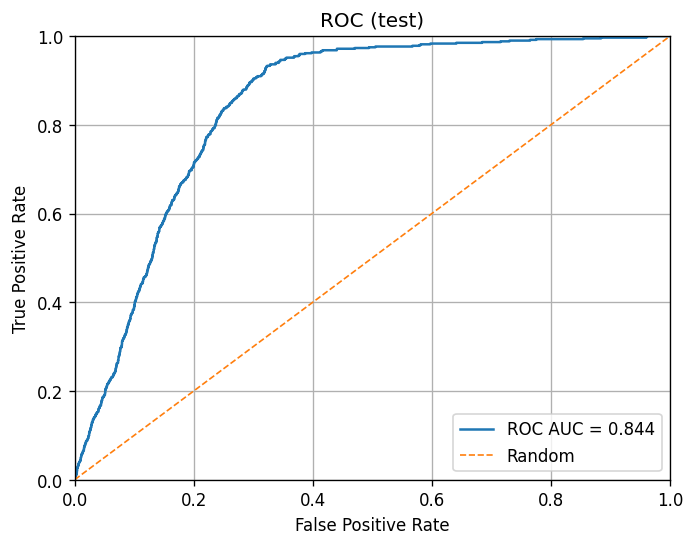

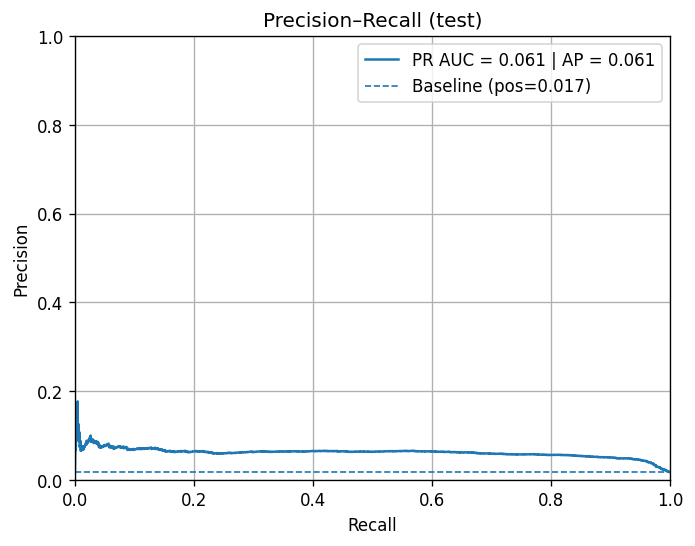

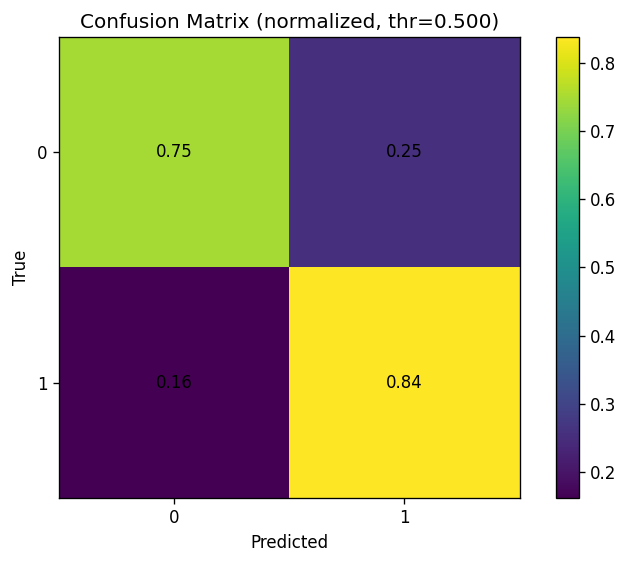

{'roc_auc_curve': 0.8441580938896078, 'pr_auc_curve': 0.060957609668458465, 'average_precision': 0.061455148363055025, 'threshold': 0.5, 'cm': [[25597, 8653], [97, 501]]}


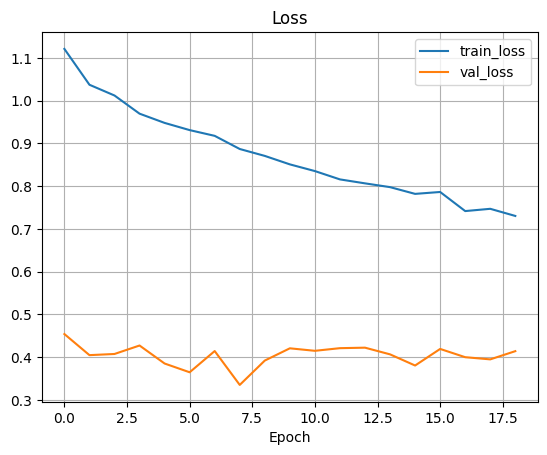

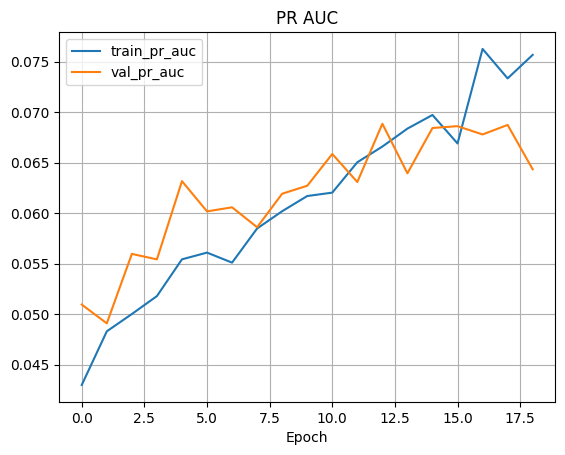

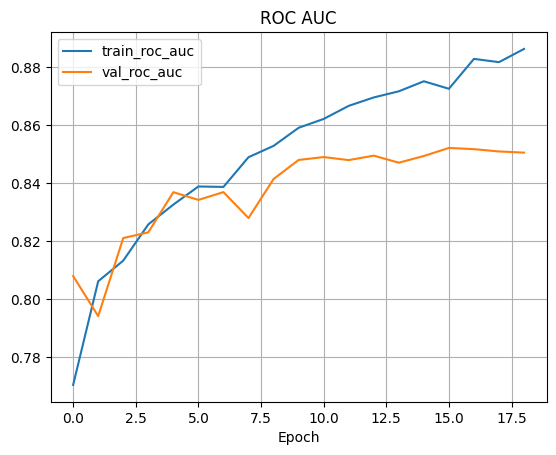

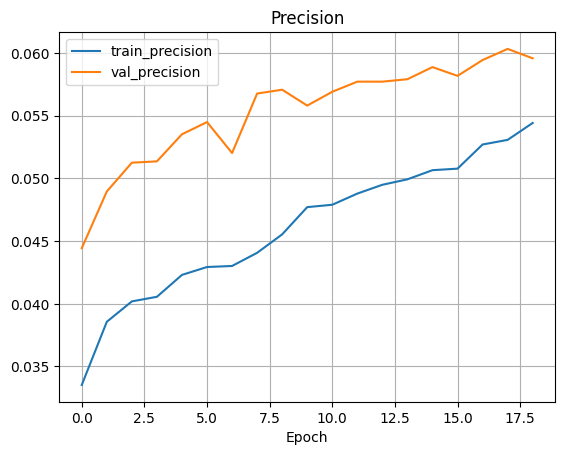

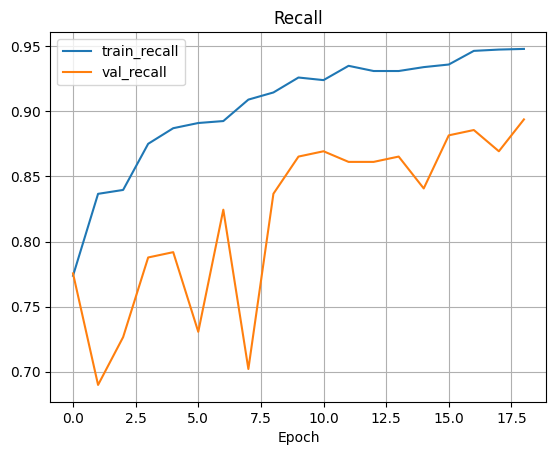

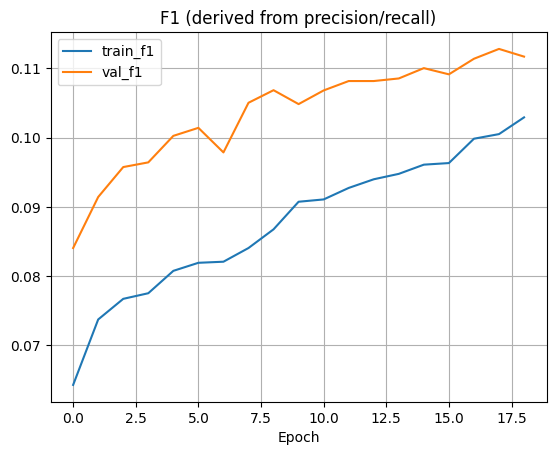

({'roc_auc': 0.8441580938896078,
  'pr_auc': 0.061455148363055025,
  'f1': 0.1027481542247744},
 '              precision    recall  f1-score   support\n\n           0      0.996     0.747     0.854     34250\n           1      0.055     0.838     0.103       598\n\n    accuracy                          0.749     34848\n   macro avg      0.525     0.793     0.478     34848\nweighted avg      0.980     0.749     0.841     34848\n',
 array([[25597,  8653],
        [   97,   501]], dtype=int64))

In [69]:
cfg = Config()
np.random.seed(cfg.seed)
tf.random.set_seed(cfg.seed)
train_and_eval(cfg) 